# AI13 Section 1 Project: 다음 분기에 어떤 게임을 설계해야할까?

# Step 1: EDA & Preprocessing

<strong>데이터 컬럼 설명</strong>

* Name: 게임 이름
* Platform: 게임 지원 플랫폼  
* Year: 출시 연도 
* Genre: 장르 
* Publisher: 게임 제작 회사  
* NA_Sales: 북미 출고량 (in millions) 
* EU_Sales: 유럽 출고량 (in millions)  
* JP_Sales: 일본 출고량 (in millions)  
* Other_Sales: 기타 출고량 (in millions)  


In [1]:
#한글 깨짐 현상 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
#라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt

In [3]:
#데이터셋 불러오기
from google.colab import files
data = files.upload()
df = pd.read_csv('vgames2.csv')

Saving vgames2.csv to vgames2 (1).csv


In [4]:
#데이터 탐색
print(df.info(), '\n')
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB
None 

         Unnamed: 0          Year
count  16598.000000  16327.000000
mean    8299.500000   1994.242543
std     4791.574219    155.077168
min        1.000000      0.000000
25%     4150.250000   2003.000000
50%     8299.500000   2007.000000
75%    12448.750000   2010.000000
max    16598.000000   2020.000000


,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


1. shape: (16598, 10)
2. 불필요한 컬럼 제거 필요: 'Unnamed: 0'
3. 결측치 처리 필요: 'Year', 'Genre', 'Publisher'
4. 출고량 데이터 타입 변경 필요: object -> float
5. 연도를 4자리 수로 통일 필요: (e.g. 09 -> 2009)

In [5]:
####삭제
df = pd.read_csv('vgames2.csv')

In [6]:
#'Unnamed: 0' column 삭제
df = df.drop(['Unnamed: 0'], axis = 1)

#결측치 개수 확인 및 제거
df.isnull().sum()
df = df.dropna() #axis = 0 (default): 결측치가 들어있는 '행' 전체 삭제

In [7]:
##'Sales'가 포함된 컬럼의 기본 단위는 M=millions로 가정한다
#'K','M' 제거
#데이터 타입 변경: object -> float

def replace(x):
   if str(x).find('K') != -1:
     return float(str(x).replace('K', ''))/1000 #K(kilo)-->M(million) 변환
   elif str(x).find('M') != -1:
     return float(str(x).replace('M', ''))
   else:
     return float(str(x))
       
for col in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
  df[col] = df[col].apply(replace)

In [8]:
#'Year' 컬럼에 있는 2자리 수 연도를 4자리 수로 바꾸기
def year(x) :
    if (x >= 0) & (x <= 22):
        return int(2000 + x)
    elif (x > 22) & (x < 1000):
        return int(1900 + x)
    else:
        return x
    
df['Year'] = df['Year'].apply(year).astype(int)

# Step 2: Feature Engineering

In [9]:
#'Global_Sales' 컬럼 추가
df['Global_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']


# Step 3: 데이터 분석

# Q1. 지역에 따라서 선호하는 게임 장르가 다를까? 

In [10]:
plt.rc('font', family='NanumBarunGothic')

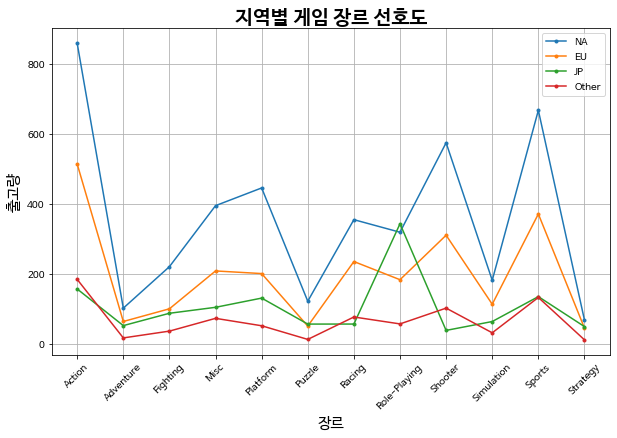

In [11]:

#장르별 게임 출고량
sales = df.groupby('Genre').sum() 

#지역에 따른 장르별 게임 출고량 시각화
sales.plot(y = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
           label = ['NA', 'EU', 'JP', 'Other'],
           marker = 'o',
           ms = 3,
           figsize = (10,6),
           grid = True
           )

#제목 및 x,y축 레이블 지정
plt.title('지역별 게임 장르 선호도', fontsize=20, fontweight = 'bold')
plt.xlabel('장르', fontsize=15)
plt.ylabel('출고량', fontsize=15)

#x-tick 보정
sales.reset_index(level=['Genre'], inplace = True) #index를 column으로 변경
genre = list(sales['Genre']) #column을 list로 변환

plt.xticks(range(len(genre)), genre, rotation = 45) #x축 눈금 빈도수 설정 및 레이블 지정

#출력
plt.show()


일본을 제외한 모든 지역에서 Action 장르 게임을 제일 선호하며 Sports와 Shooter 장르가 그 다음으로 높은 선호도를 가집니다.   
장르별 선호도가 대체로 유사합니다.  

반면에 일본에서는 Role-Playing 장르를 제일 선호하며 그 다음으로 Action과 Platform 장르가 인기 있습니다.  

모든 지역에서 상위 랭크를 차지하는 Action 장르를 출시하는 것이 안정적인 방법으로 예상됩니다.

# Q2. 연도에 따른 게임 트렌드가 있을까?

* 연도별 총 게임 출고량
* 연도별 인기 장르

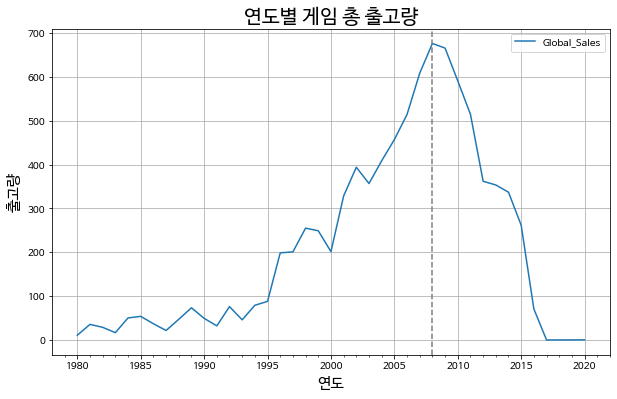

In [12]:
#1. 연도별 총 게임 출고량
sales_yr = df.groupby('Year').sum()

#연도별 총 게임 출고량 시각화


ax = sales_yr.plot(y = 'Global_Sales', 
                   grid = True,
                   figsize = (10,6))

#x축 보조눈금 추가
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.yaxis.set_tick_params(which='minor', bottom=False)


plt.title('연도별 게임 총 출고량', fontsize=20)
plt.xlabel('연도', fontsize=15)
plt.ylabel('출고량', fontsize=15)

#'Global_Sales'가 최대 값을 가지는 연도 찾기
#sales_yr[sales_yr['Global_Sales'] == sales_yr['Global_Sales'].max()] 
plt.axvline(x=2008, color='grey', linestyle='--')

plt.show()

전체 게임 출고량은 1980년대 출시 이후 지속적인 성장세를 보이다 2008년에 역대 최대 게임 출고량을 기록했습니다.  
그러나 2008년 이후 가파른 하향세를 보였습니다. 

In [13]:
#연도별 최고 인기 장르 및 출고량
df2 = df.groupby(['Year', 'Genre'])[['Global_Sales']].sum()
df3 = df2.groupby(['Year'])[['Global_Sales']].transform('max')
df2['Rank1'] = df3['Global_Sales']

condition = df2['Rank1'] == df2['Global_Sales']
df4 = df2[condition].reset_index()
df5 = df4.drop('Rank1', inplace = True, axis=1)
df5 = df4.drop('Global_Sales', axis=1)

df5.rename(columns ={'Genre': 'Most_Popular_Genre'}, inplace = True)


df1900s = df5.iloc[:20,:].style.hide_index()
df2000s = df5.iloc[20:,:].style.hide_index()

df1900s
df2000s

Year,Most_Popular_Genre
2000,Sports
2001,Action
2002,Action
2003,Action
2004,Action
2005,Action
2006,Sports
2007,Action
2008,Action
2009,Sports


1980-2000년도에는 Platform 장르가, 2000-2020년도에는 Action 장르가 인기가 많았습니다.


정말로 인기 장르가 시대에 따라서 변하는지, 연관성을 알아보기 위해  
독립성을 보여주는 2 sample 카이 제곱 테스트로 가설검정을 진행했습니다.

* 귀무가설: 연대에 상관없이 인기 장르는 같다. (관련 없음)  
* 대립가설: 연대에 따라서 인기 장르는 다르다. (관련 있음)
* 신뢰도: 95%

In [14]:
#two sample chi-square test: 연대와 인기 장르의 독립성 검증
#10년 주기별 장르에 따른 총 출고량
df1980s = df[df['Year'] <= 1990].groupby('Genre')['Global_Sales'].sum()
df1980s['Strategy'] = 0

df1990s = df[(df['Year'] > 1990)&(df['Year'] <= 2000)].groupby('Genre')['Global_Sales'].sum()
df2000s = df[(df['Year'] > 2000)&(df['Year'] <= 2010)].groupby('Genre')['Global_Sales'].sum()
df2010s = df[(df['Year'] > 2010)&(df['Year'] <= 2020)].groupby('Genre')['Global_Sales'].sum()

data = pd.DataFrame([df1980s, df1990s, df2000s, df2010s],
                  index = ['1980','1990','2000','2010'])

chi = stats.chi2_contingency(data)
print('chi_square statistics:', chi[0])
print('p-value:', chi[1])
print('\n')
data

chi_square statistics: 1441.8657299624867
p-value: 3.1222171688318977e-282




Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
1980,57.49,4.78,7.24,8.44,145.24,68.74,18.35,19.77,59.77,1.64,33.89,0.00
1990,166.65,47.76,143.77,78.98,201.94,36.78,162.56,207.29,75.72,54.28,185.60,66.03
2000,936.74,137.20,225.88,551.38,392.06,125.18,452.93,453.72,504.06,284.17,853.59,85.12
2010,552.10,44.28,66.65,140.90,88.75,10.03,88.71,220.73,385.20,49.19,232.26,21.83


# Q3. 출고량이 높은 게임의 특징은 뭘까?

In [15]:
#역대 출고량 상위 100개 
df_sort = df.sort_values(['Global_Sales'], ascending = False)
df_sort = df_sort.drop(columns =['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
df_best = df_sort.head(100).reset_index(drop=True)

df_best.head(10)

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.83
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,31.38
5,Tetris,GB,1989,Puzzle,Nintendo,30.26
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,30.01
7,Wii Play,Wii,2006,Misc,Nintendo,29.01
8,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,28.61
9,Duck Hunt,NES,1984,Shooter,Nintendo,28.31


Text(0.5, 1.0, '플랫폼 비율')

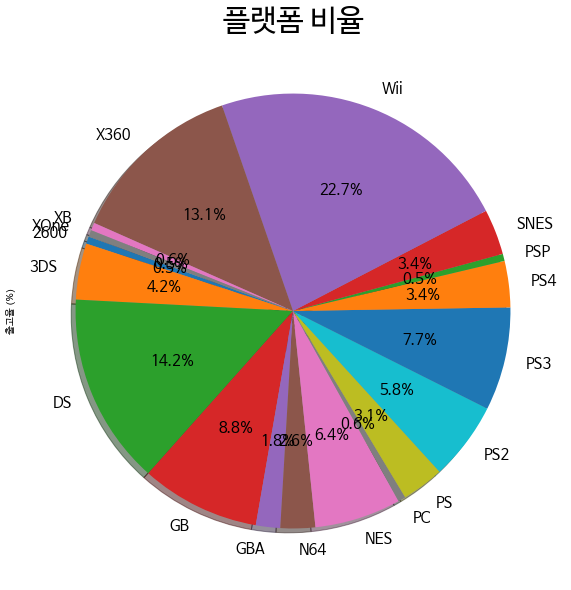

In [22]:
#상위 인기 출고량에서 플랫폼별 비율 시각화
df_platform = df_best.groupby(['Platform'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('플랫폼 비율', fontsize=30)

Text(0.5, 1.0, '제작회사 비율')

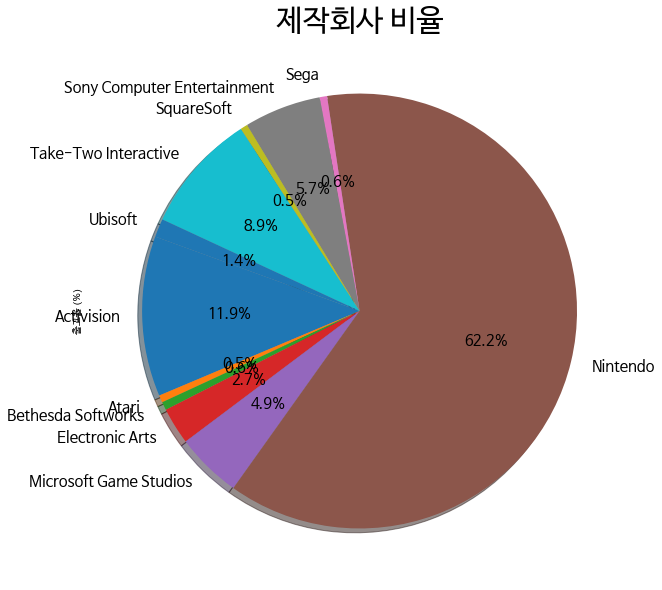

In [27]:
#상위 인기 출고량에서 제작회사별 비율 시각화
df_platform = df_best.groupby(['Publisher'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('제작회사 비율', fontsize=30)

Text(0.5, 1.0, '장르 비율')

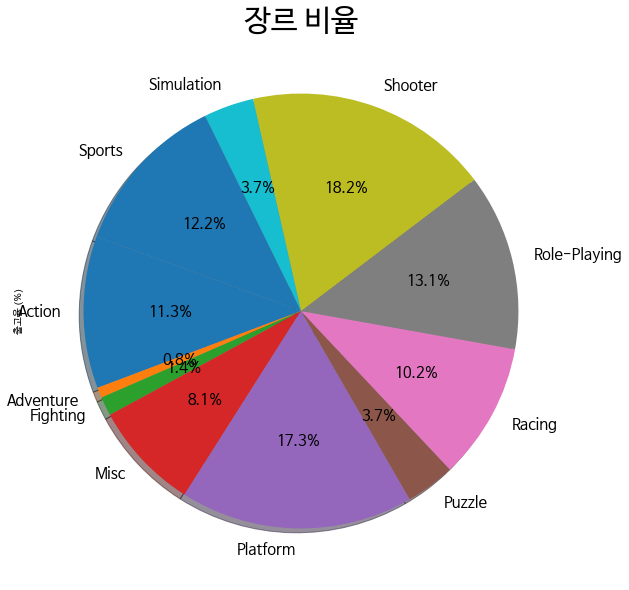

In [26]:
#상위 인기 출고량에서 장르별 비율 시각화
df_platform = df_best.groupby(['Genre'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('장르 비율', fontsize=30)

Text(0.5, 1.0, '연도 비율')

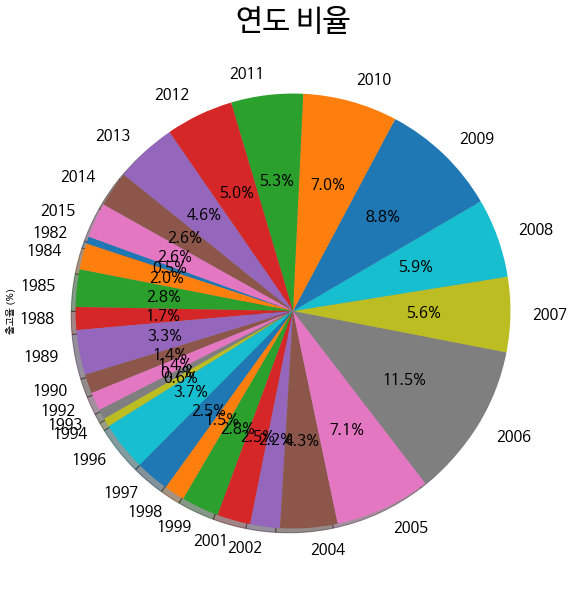

In [28]:
#상위 인기 출고량에서 연도별 비율 시각화
df_platform = df_best.groupby(['Year'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('연도 비율', fontsize=30)

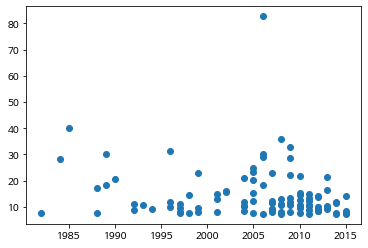

In [20]:
#연도에 따른 데이터 산점도
plt.scatter(df_best['Year'],df_best['Global_Sales'])
plt.show()

높은 출고량을 가진 역대 상위 게임들을 분석한 결과, 최근 트렌드를 반영하고 있지 않다고 판단했습니다.  
따라서, 앞서 확인된 최근 10년 이내의 선호 장르인 **Action 장르를 기준**으로 높은 출고량에 대한 분석을 다시 진행했습니다.

In [34]:
#역대 출고량 상위 100개 (Action 장르) 
df_sort2 = df.sort_values(['Global_Sales'], ascending = False)
df_sort2 = df_sort2.drop(columns =['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

condition = df_sort2['Genre'] == 'Action'
df_sort2 = df_sort2[condition]
df_best2 = df_sort2.head(100).reset_index(drop=True)

df_best2.head(10)

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,21.39
1,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,20.81
2,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,16.38
3,Grand Theft Auto: Vice City,PS2,2002,Action,Take-Two Interactive,16.15
4,Grand Theft Auto III,PS2,2001,Action,Take-Two Interactive,13.10
5,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,11.99
6,Pokemon HeartGold/Pokemon SoulSilver,DS,2009,Action,Nintendo,11.90
7,Grand Theft Auto IV,X360,2008,Action,Take-Two Interactive,11.03
8,Grand Theft Auto IV,PS3,2008,Action,Take-Two Interactive,10.58
9,FIFA Soccer 13,PS3,2012,Action,Electronic Arts,8.25


Text(0.5, 1.0, '플랫폼 비율')

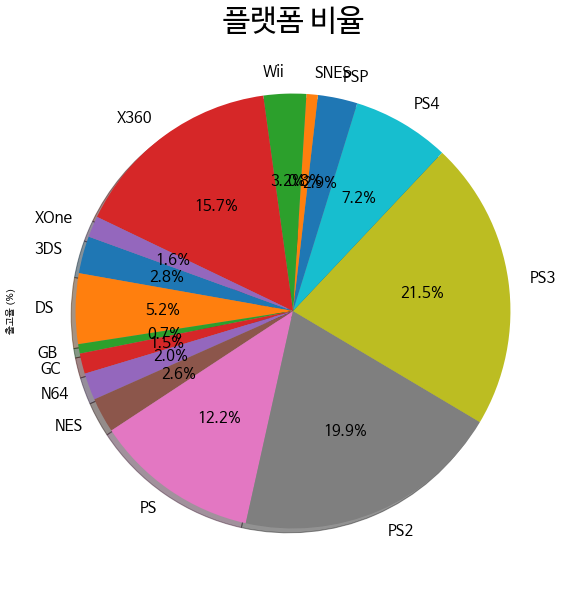

In [35]:
#상위 인기 출고량에서 플랫폼별 비율 시각화 (Action 장르)
df_platform = df_best2.groupby(['Platform'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('플랫폼 비율', fontsize=30)

Text(0.5, 1.0, '제작회사 비율')

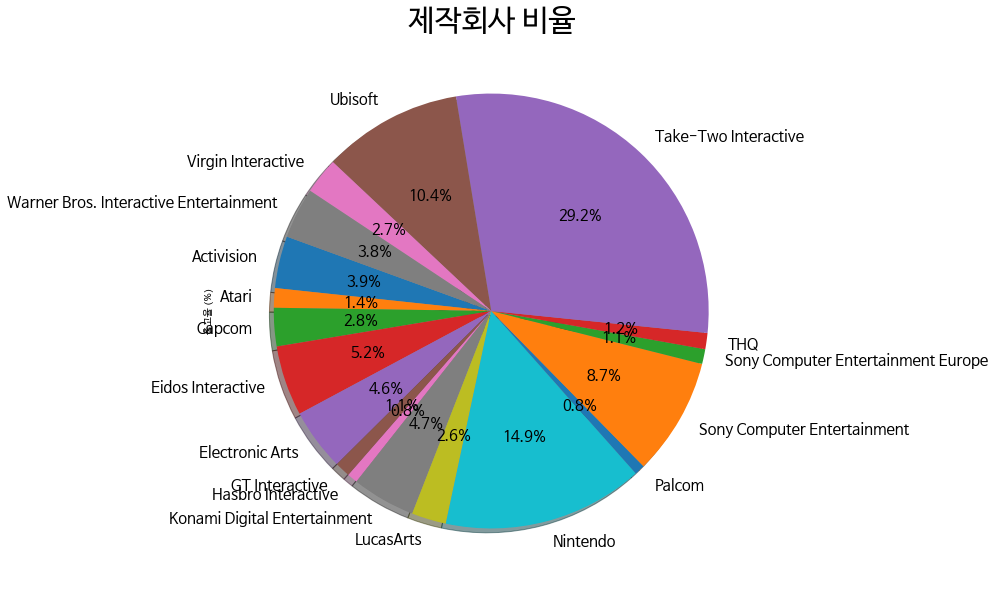

In [37]:
#상위 인기 출고량에서 제작회사별 비율 시각화 (Action 장르)
df_platform = df_best2.groupby(['Publisher'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('제작회사 비율', fontsize=30)

Text(0.5, 1.0, '연도 비율')

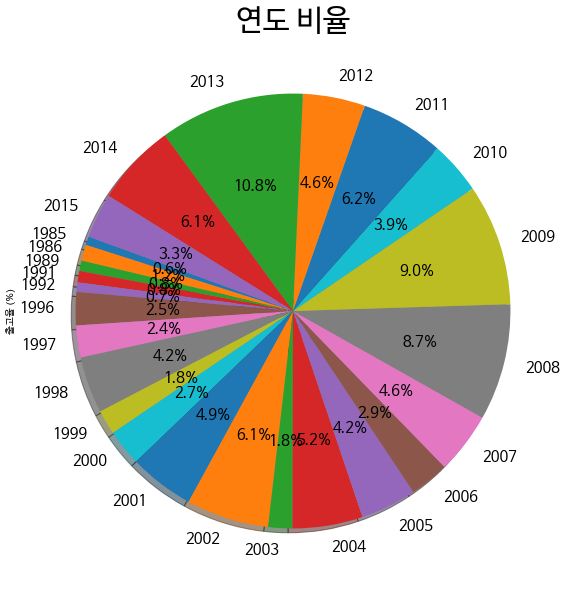

In [38]:
#상위 인기 출고량에서 연도별 비율 시각화 (Action 장르)
df_platform = df_best2.groupby(['Year'])['Global_Sales'].sum()
df_platform = df_platform.to_frame()


sum = df_platform['Global_Sales'].sum()

df_platform["출고율 (%)"] = round((df_platform['Global_Sales'] / sum) * 100, 2)
df_platform.head()

plt.figure(figsize=(10, 10))
df_platform['출고율 (%)'].plot(kind = "pie", autopct = '%1.1f%%', startangle = 160, shadow = True, textprops={'size': 15})
plt.title('연도 비율', fontsize=30)

# Step 4: 결론

그래서 다음 분기에 어떤 게임을 설계해야 할까?

In [ ]:
#연도별 데이터 수
df6 = pd.DataFrame(df['Year'].value_counts()).reset_index()
df6.columns = ['Year', 'Num_of_data']
df6 = df6.sort_values(['Year'])
df6.plot(x = 'Year',
         y = 'Num_of_data',
         label = 'Number of data',
         grid = True,
         figsize = (10,6)
         )
plt.title('연도별 데이터 수', fontsize = 20)
plt.xlabel('연도', fontsize = 15)
plt.ylabel('데이터 수', fontsize = 15)

In [ ]:
df6.tail(10).style.hide_index()